## GROUND SEGMENTATION TEST

In [9]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.0.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import cv2

In [25]:
IMG_SIZE = (256, 256)
NUM_CLASSES = 1

In [26]:
def load_and_preprocess_image(img_path, img_size=IMG_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

def load_test_data(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    images = [load_and_preprocess_image(p) for p in image_paths]
    return tf.stack(images), mask_paths, image_paths

In [27]:
def test_model(model_path, test_image_dir, test_mask_dir, visualize=True):
    model = load_model(model_path, compile=False)
    images, mask_paths, image_paths = load_test_data(test_image_dir, test_mask_dir)

    total_acc = []

    for i in range(len(images)):
        img = tf.expand_dims(images[i], axis=0)
        pred = model.predict(img, verbose=0)[0]  # (H, W, 1)
        pred_mask = (pred > 0.5).astype(np.uint8).squeeze()

        true_mask = tf.io.read_file(mask_paths[i])
        true_mask = tf.image.decode_png(true_mask, channels=1)
        true_mask = tf.image.resize(true_mask, IMG_SIZE, method='nearest')
        true_mask = tf.squeeze(true_mask).numpy().astype(np.uint8)
        true_mask = (true_mask > 127).astype(np.uint8)  # ensure binary

        acc = accuracy_score(true_mask.flatten(), pred_mask.flatten())
        total_acc.append(acc)

        if visualize:
            input_img = (images[i].numpy() * 255).astype(np.uint8)
            if input_img.shape[-1] == 1:
                input_img = np.repeat(input_img, 3, axis=-1)

            overlay_img = input_img.copy()
            overlay_img[pred_mask == 1] = [255, 0, 0]  # Red mask
            blended = cv2.addWeighted(input_img, 0.5, overlay_img, 0.5, 0)

            plt.figure(figsize=(16, 4))
            plt.subplot(1, 4, 1)
            plt.imshow(input_img)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 4, 2)
            plt.imshow(pred_mask, cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(1, 4, 3)
            plt.imshow(true_mask, cmap="gray")
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.subplot(1, 4, 4)
            plt.imshow(blended)
            plt.title("Overlay (Sheer Red)")
            plt.axis("off")

            plt.suptitle(f"Test Image {i+1} | Accuracy: {acc:.4f}")
            plt.tight_layout()
            plt.show()

    print(f"\nModel: {os.path.basename(model_path)}")
    print(f"Average Test Accuracy ({len(images)} images): {np.mean(total_acc)*100:.2f}%")

### EfficientNetB3 UNet One

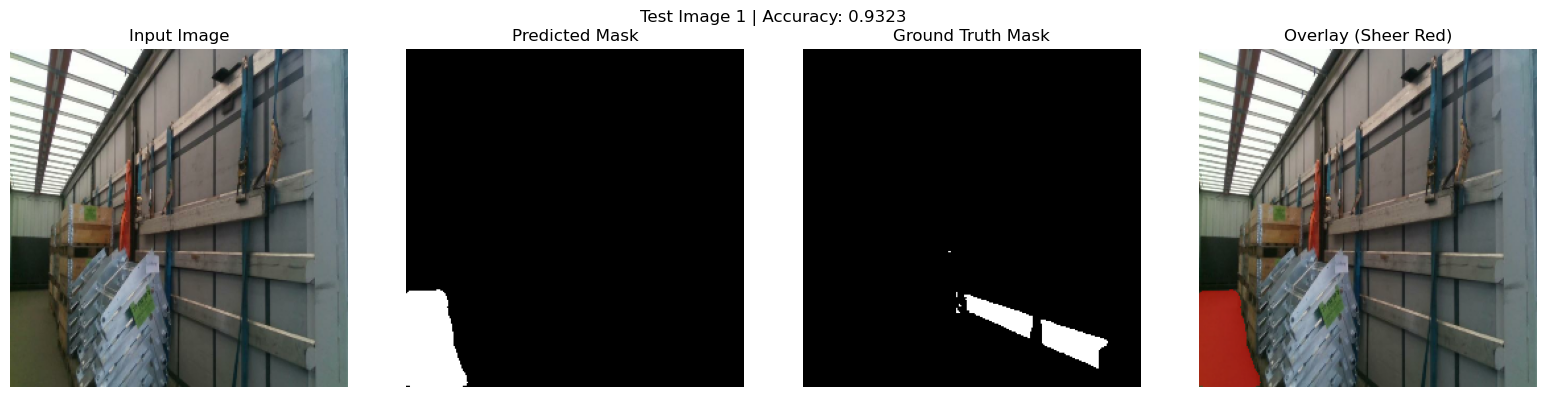

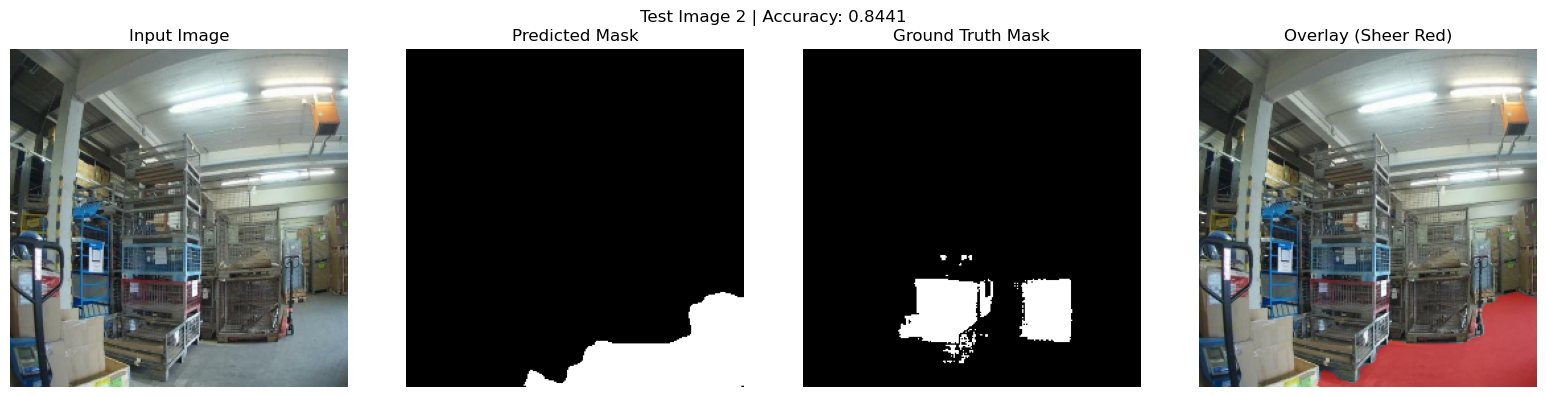

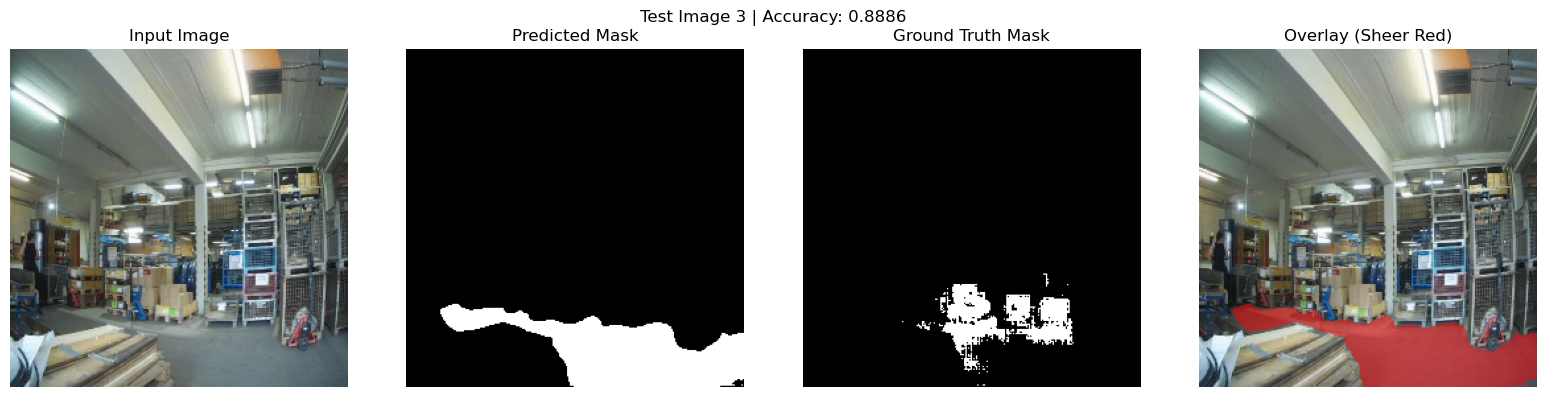

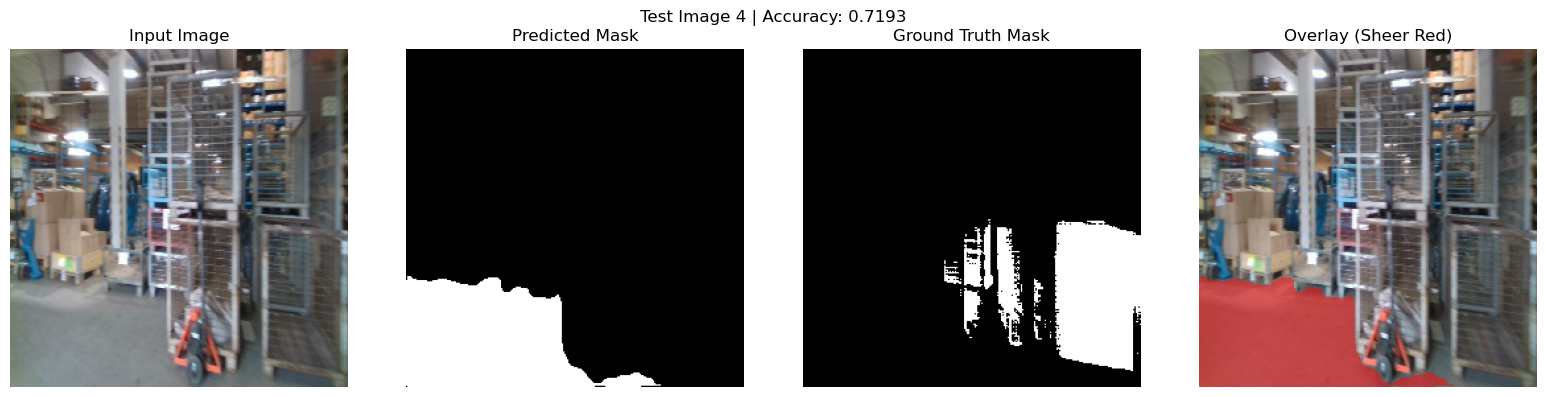

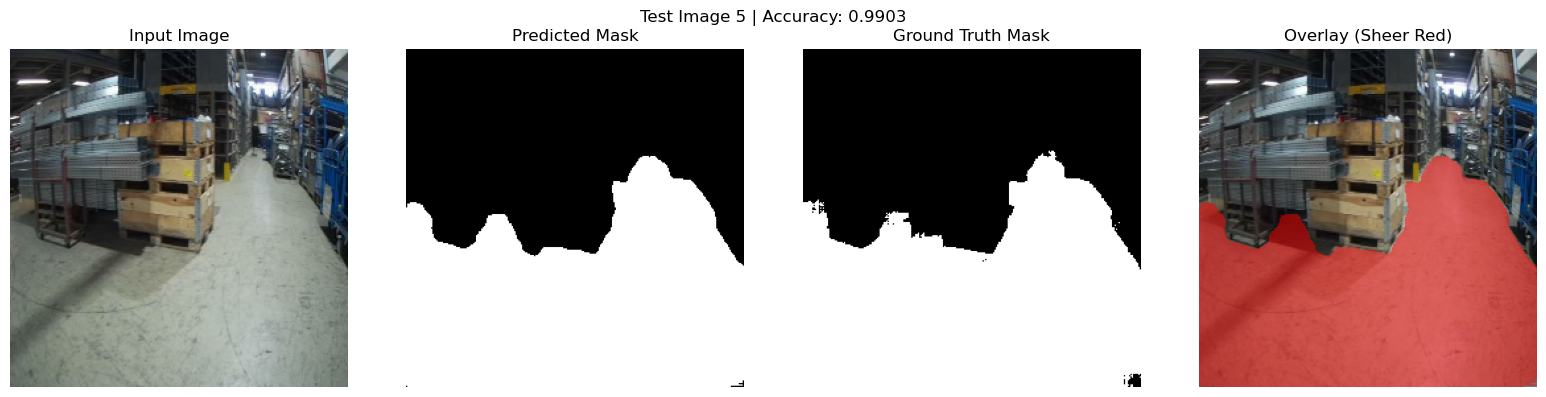

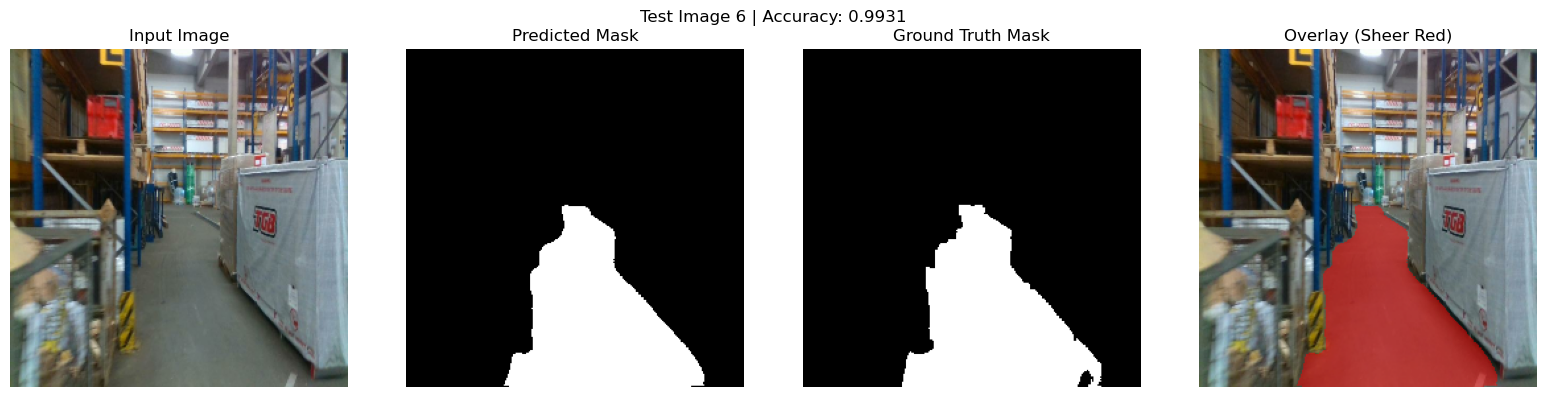

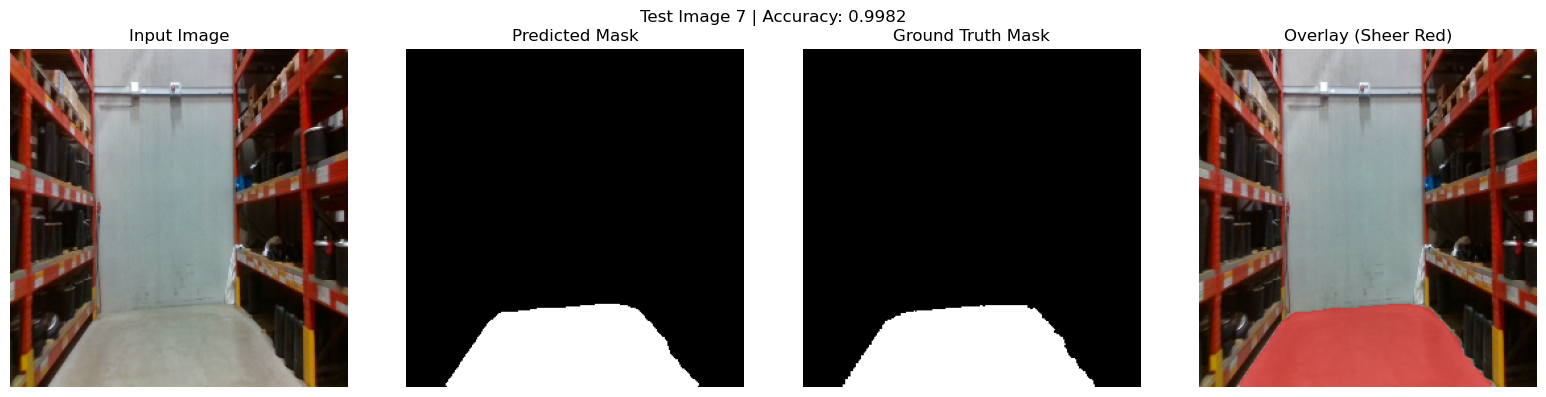

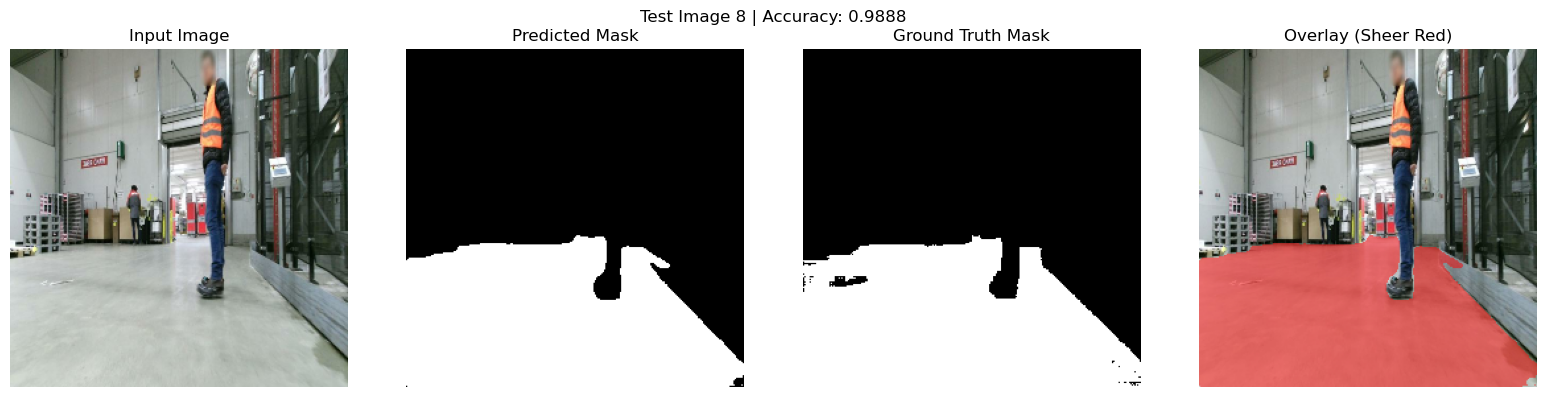

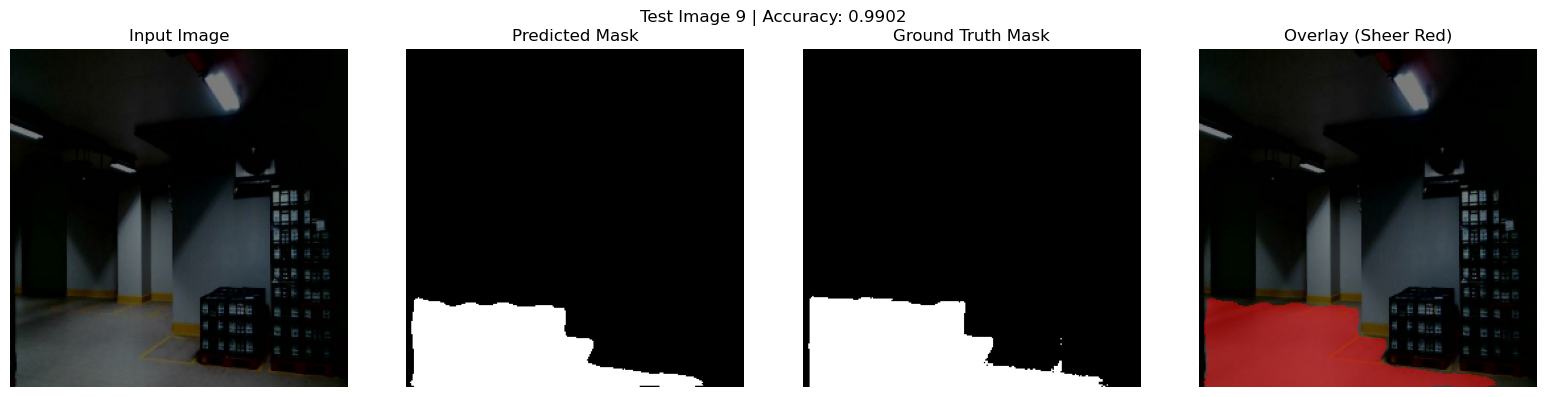

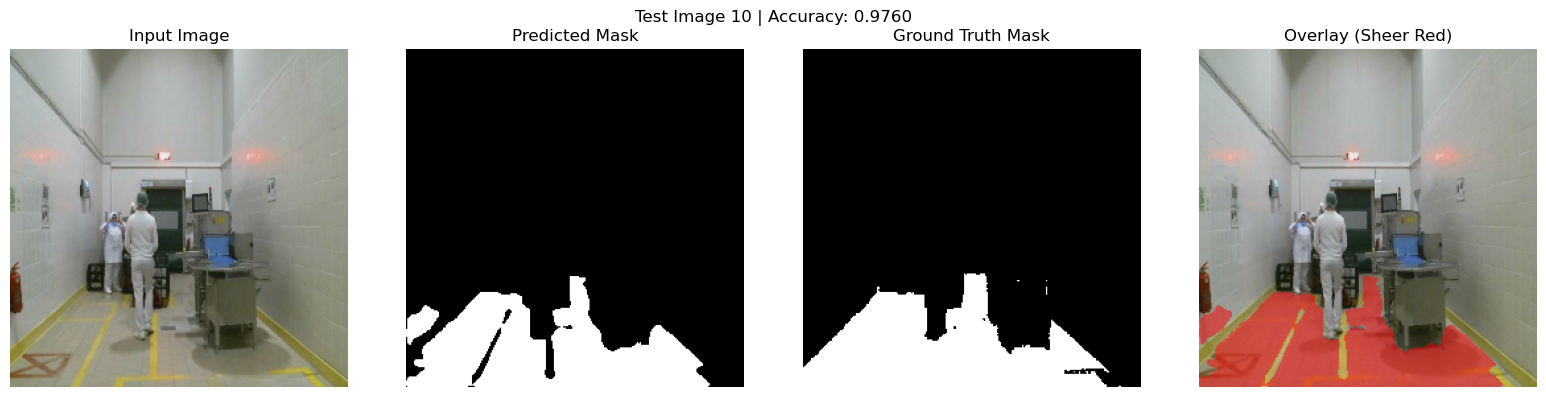


✅ Model: best_model_epoch52_valacc0.99.h5
🧠 Average Test Accuracy (10 images): 93.21%


In [28]:
model_path = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\models\best_model_epoch52_valacc0.99.h5"
test_image_dir = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images"
test_mask_dir = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\masks"

test_model(model_path, test_image_dir, test_mask_dir)

### EfficientNetB3 UNet Same but new data

In [29]:
# --- Load and preprocess image ---
def load_and_preprocess_image(img_path, img_size=IMG_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

# --- Load test data ---
def load_test_data(image_dir):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    images = [load_and_preprocess_image(p) for p in image_paths]
    return tf.stack(images), image_paths

In [30]:
# --- Test best model and visualize ---
def test_model(model_path, test_image_dir, visualize=True):
    model = load_model(model_path, compile=False)
    images, image_paths = load_test_data(test_image_dir)

    total_acc = []

    for i in range(len(images)):
        img = tf.expand_dims(images[i], axis=0)
        pred = model.predict(img, verbose=0)[0]  # (H, W, 1)
        pred_mask = (pred > 0.5).astype(np.uint8).squeeze()

        if visualize:
            # Convert input image back to displayable format if needed
            input_img = (images[i].numpy() * 255).astype(np.uint8)
            if input_img.shape[-1] == 1:
                input_img = np.repeat(input_img, 3, axis=-1)

            # Create overlay
            overlay_img = input_img.copy()
            overlay_img[pred_mask == 1] = [255, 0, 0]  # Red mask
            blended = cv2.addWeighted(input_img, 0.5, overlay_img, 0.5, 0)

            plt.figure(figsize=(16, 3))
            plt.subplot(1, 4, 1)
            plt.imshow(input_img)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 4, 2)
            plt.imshow(pred_mask, cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(1, 4, 3)
            plt.imshow(blended)
            plt.title("Overlay (Sheer Red)")
            plt.axis("off")

    print(f"\n✅ Model: {os.path.basename(model_path)}")


✅ Model: best_model_epoch52_valacc0.99.h5


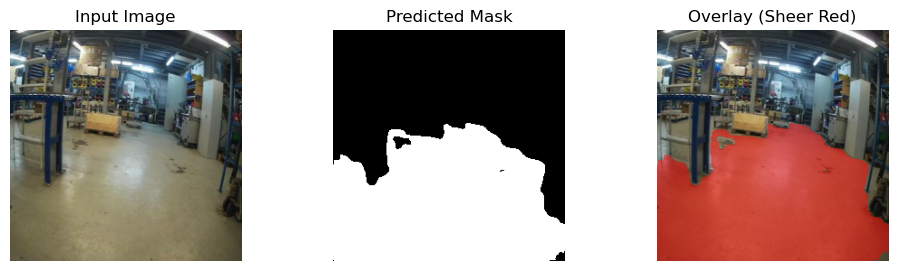

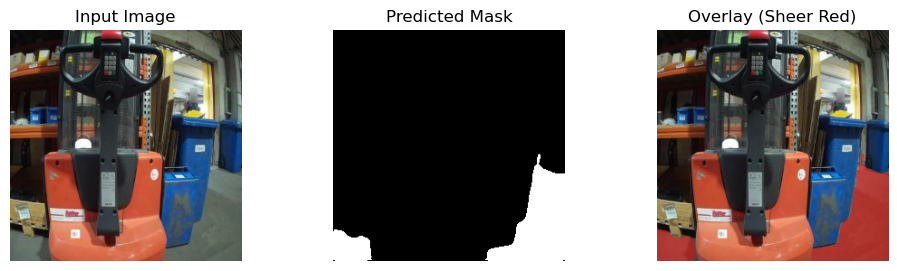

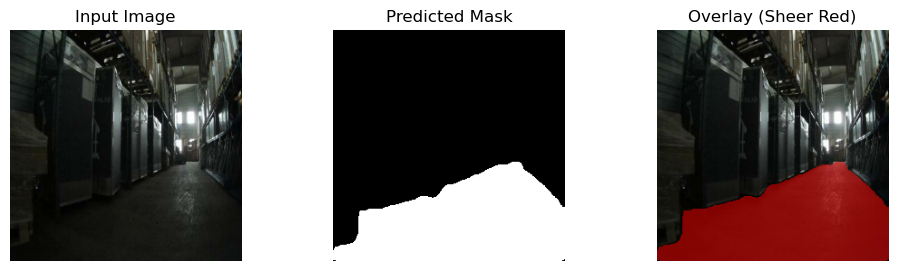

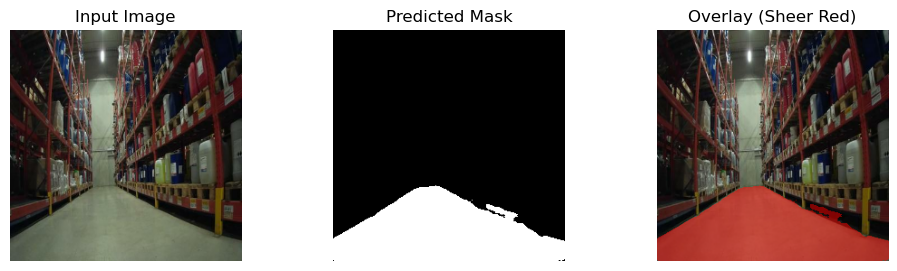

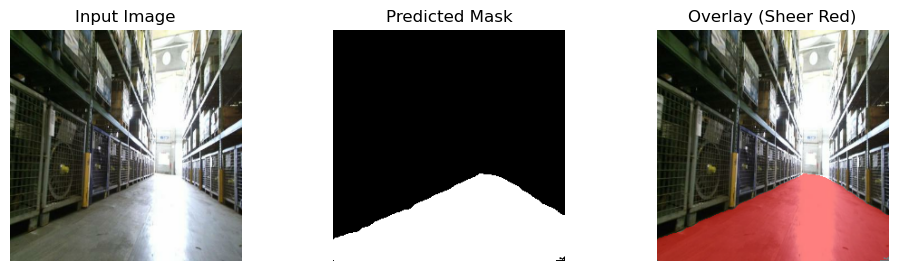

In [31]:
model_path = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\models\best_model_epoch52_valacc0.99.h5"
test_image_dir = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_new"

test_model(model_path, test_image_dir)

## PALLET OBJECT DETECTION

### YOLOv8 - No changes run

In [32]:
pip install ultralytics --upgrade

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/978.8 kB ? eta -:--:--
   ---------------------------------------- 978.8/978.8 kB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
from ultralytics import YOLO
import os

In [4]:
model_path = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\models\best_epoch78_mAP0.825.pt"

image_folder = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj"

output_folder = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\predictions"
os.makedirs(output_folder, exist_ok=True)

model = YOLO(model_path)

results = model.predict(
    source=image_folder,
    conf=0.6,                
    save=True,              
    save_txt=True,         
    save_conf=True,         
    project=output_folder,
    name="yolo_outputs",
    exist_ok=True
)


image 1/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1564562613-255014_jpg.rf.dfed1a365c82eb81b670037127435605.jpg: 640x640 16 0s, 142.1ms
image 2/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1564563774-3722231_jpg.rf.ad1a99187b5100b7fd724f42760d75bc.jpg: 640x640 5 0s, 133.7ms
image 3/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1564564014-565895_jpg.rf.46e53299ab93c39e5cfc7601cd527d10.jpg: 640x640 4 0s, 162.8ms
image 4/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1576593048-460317_jpg.rf.7e5ddeda5f7110ac6b21218edb9acbd1.jpg: 640x640 12 0s, 177.8ms
image 5/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1583416245-1752756_jpg.rf.a7d40fa5a77876fa3c0a601bbf1e53d9.jpg: 640x640 1 0, 157.3ms
image 6/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1583416705-641938_jpg.rf.a1699f84783922bbfdaa2a3f098bc204.jpg: 640x640 69 0s, 1

### YOLOv8 Augmentation

In [1]:
from ultralytics import YOLO
import os

In [2]:
model_path = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\models\best_epoch87_mAP0.833.pt"

image_folder = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj"

output_folder = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\predictions"
os.makedirs(output_folder, exist_ok=True)

model = YOLO(model_path)

results = model.predict(
    source=image_folder,
    conf=0.6,                
    save=True,          
    save_txt=True,      
    save_conf=True,         
    project=output_folder,
    name="yolo_outputs",
    exist_ok=True
)


image 1/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1564562613-255014_jpg.rf.dfed1a365c82eb81b670037127435605.jpg: 640x640 17 0s, 195.0ms
image 2/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1564563774-3722231_jpg.rf.ad1a99187b5100b7fd724f42760d75bc.jpg: 640x640 6 0s, 132.0ms
image 3/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1564564014-565895_jpg.rf.46e53299ab93c39e5cfc7601cd527d10.jpg: 640x640 3 0s, 132.7ms
image 4/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1576593048-460317_jpg.rf.7e5ddeda5f7110ac6b21218edb9acbd1.jpg: 640x640 12 0s, 129.9ms
image 5/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1583416245-1752756_jpg.rf.a7d40fa5a77876fa3c0a601bbf1e53d9.jpg: 640x640 1 0, 142.1ms
image 6/6 C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj\1583416705-641938_jpg.rf.a1699f84783922bbfdaa2a3f098bc204.jpg: 640x640 70 0s, 1

## SEG + OBJ DET

### YOLOv8 No Changes + Segmentation

In [40]:
from ultralytics import YOLO
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [37]:
yolo_model_path = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\models\best_epoch78_mAP0.825.pt"
unet_model_path = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\models\best_model_epoch52_valacc0.99.h5"

yolo_model = YOLO(yolo_model_path)
unet_model = load_model(unet_model_path, compile=False)

In [41]:
def run_combined_inference_on_folder(image_dir, yolo_model, unet_model, output_dir=None, input_size=(256, 256)):
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    for image_path in image_paths:
        original = cv2.imread(image_path)
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        h0, w0 = original.shape[:2]

        image_resized = cv2.resize(original_rgb, input_size) / 255.0
        image_input = np.expand_dims(image_resized, axis=0)
        seg_mask = unet_model.predict(image_input)[0, :, :, 0]
        seg_mask = (seg_mask > 0.5).astype(np.uint8)
        seg_mask = cv2.resize(seg_mask, (w0, h0), interpolation=cv2.INTER_NEAREST)

        overlay = original_rgb.copy()
        overlay[seg_mask == 1] = [0, 255, 0]  # green mask
        blended = cv2.addWeighted(original_rgb, 0.7, overlay, 0.3, 0)

        results = yolo_model.predict(source=image_path, conf=0.4, save=False, verbose=False)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        scores = results[0].boxes.conf.cpu().numpy()

        for box, score in zip(boxes, scores):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(blended, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(blended, f'{score:.2f}', (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        filename = os.path.basename(image_path)
        if output_dir:
            save_path = os.path.join(output_dir, filename)
            cv2.imwrite(save_path, cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))
        else:
            plt.figure(figsize=(10, 10))
            plt.imshow(blended)
            plt.title(f"Result: {filename}")
            plt.axis('off')
            plt.show()

In [42]:
image_dir = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj"
output_dir = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\predictions"

run_combined_inference_on_folder(image_dir, yolo_model, unet_model, output_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


### YOLOv8 Augmented + Segmentation

In [2]:
from ultralytics import YOLO
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [3]:
yolo_model_path = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\models\best_epoch87_mAP0.833.pt"
unet_model_path = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\models\best_model_epoch52_valacc0.99.h5"

yolo_model = YOLO(yolo_model_path)
unet_model = load_model(unet_model_path, compile=False)

In [4]:
def run_combined_inference_on_folder(image_dir, yolo_model, unet_model, output_dir=None, input_size=(256, 256)):
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    for image_path in image_paths:
        original = cv2.imread(image_path)
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        h0, w0 = original.shape[:2]

        image_resized = cv2.resize(original_rgb, input_size) / 255.0
        image_input = np.expand_dims(image_resized, axis=0)
        seg_mask = unet_model.predict(image_input)[0, :, :, 0]
        seg_mask = (seg_mask > 0.5).astype(np.uint8)
        seg_mask = cv2.resize(seg_mask, (w0, h0), interpolation=cv2.INTER_NEAREST)

        overlay = original_rgb.copy()
        overlay[seg_mask == 1] = [0, 255, 0]  # green mask
        blended = cv2.addWeighted(original_rgb, 0.7, overlay, 0.3, 0)

        results = yolo_model.predict(source=image_path, conf=0.6, save=False, verbose=False)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        scores = results[0].boxes.conf.cpu().numpy()

        for box, score in zip(boxes, scores):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(blended, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(blended, f'{score:.2f}', (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        filename = os.path.basename(image_path)
        if output_dir:
            save_path = os.path.join(output_dir, filename)
            cv2.imwrite(save_path, cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))
        else:
            plt.figure(figsize=(10, 10))
            plt.imshow(blended)
            plt.title(f"Result: {filename}")
            plt.axis('off')
            plt.show()

In [ ]:
image_dir = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\images_obj"
output_dir = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\predictions"

run_combined_inference_on_folder(image_dir, yolo_model, unet_model, output_dir)

In [5]:
image_dir = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\img"
output_dir = r"C:\Users\ksaks\Documents\Masters Stuff\PR\EuroPalletSeg\test\img_pred"

run_combined_inference_on_folder(image_dir, yolo_model, unet_model, output_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
